In [1]:
!pip install yfinance pandas numpy matplotlib statsmodels pmdarima seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.9 MB/s eta 0:00:00


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:

import os
import warnings
warnings.filterwarnings('ignore')

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller


In [16]:

# ---------------------------
# Configuration
# ---------------------------
TICKERS = ["TSLA", "BND", "SPY"]
START_DATE = "2015-07-01"
END_DATE = "2025-07-31"  # inclusive intent
OUTPUT_DIR = "outputs"
ROLL_WINDOW = 30  # rolling window size for volatility
RISK_FREE_RATE = 0.02  # annual risk-free rate used for Sharpe calculation
TRADING_DAYS = 252
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------------------------
# Utility functions
# ---------------------------

def download_data(tickers, start, end):
    dfs = {}
    for t in tickers:
        print(f"Downloading {t}...")
        df = yf.download(t, start=start, end=end, progress=False)
        if df.empty:
            raise RuntimeError(f"No data returned for {t}. Check ticker or date range.")
        dfs[t] = df
    return dfs


def clean_and_engineer(df, roll_window=30):
    df = df.copy()
    # Ensure datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    # Sort index
    df.sort_index(inplace=True)

    # Forward fill then back fill to handle missing market-days
    df.ffill(inplace=True)
    df.bfill(inplace=True)

    # Feature engineering
    df['Adj Close'] = df.get('Adj Close', df['Close'])
    df['Daily_Return'] = df['Adj Close'].pct_change()
    df['Log_Return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
    df['Rolling_Volatility'] = df['Daily_Return'].rolling(window=roll_window).std()
    df['Rolling_Mean'] = df['Adj Close'].rolling(window=roll_window).mean()

    return df


def plot_price_series(dfs, output_path=None):
    plt.figure(figsize=(12,6))
    for t, df in dfs.items():
        plt.plot(df.index, df['Adj Close'], label=t)
    plt.title('Adjusted Close Price (2015-07-01 to 2025-07-31)')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    if output_path:
        plt.savefig(output_path, bbox_inches='tight')
    plt.show()


def plot_daily_returns_hist(dfs, output_path=None):
    plt.figure(figsize=(12,6))
    for t, df in dfs.items():
        sns.kdeplot(df['Daily_Return'].dropna(), label=t, fill=False)
    plt.title('Daily Returns KDE (2015-2025)')
    plt.xlabel('Daily Return')
    plt.legend()
    if output_path:
        plt.savefig(output_path, bbox_inches='tight')
    plt.show()


def plot_rolling_volatility(dfs, output_path=None):
    plt.figure(figsize=(12,6))
    for t, df in dfs.items():
        plt.plot(df.index, df['Rolling_Volatility'], label=t)
    plt.title(f'{ROLL_WINDOW}-Day Rolling Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility (std of daily returns)')
    plt.legend()
    if output_path:
        plt.savefig(output_path, bbox_inches='tight')
    plt.show()


def detect_outliers(df, k=3):
    # flag returns beyond k * std as outliers
    thr = k * df['Daily_Return'].std()
    out = df[np.abs(df['Daily_Return']) > thr]
    return out


def adf_test(series, name='series'):
    series = series.dropna()
    if len(series) < 10:
        print(f"Not enough observations for ADF on {name}")
        return None
    result = adfuller(series, autolag='AIC')
    output = {
        'ADF Statistic': result[0],
        'p-value': result[1],
        'usedlag': result[2],
        'nobs': result[3],
        'crit_vals': result[4]
    }
    print(f"ADF test for {name} -> ADF={output['ADF Statistic']:.4f}, p={output['p-value']:.4f}")
    for k, v in output['crit_vals'].items():
        print(f"   {k} : {v:.4f}")
    if output['p-value'] <= 0.05:
        print('   => Likely stationary (reject H0)')
    else:
        print('   => Likely non-stationary (fail to reject H0)')
    print('')
    return output


def compute_risk_metrics(df, risk_free_rate=0.02):
    dr = df['Daily_Return'].dropna()
    if dr.empty:
        return {'VaR_95': np.nan, 'Sharpe': np.nan}
    var_95 = np.percentile(dr, 5)
    ann_mean = dr.mean() * TRADING_DAYS
    ann_std = dr.std() * np.sqrt(TRADING_DAYS)
    sharpe = (ann_mean - risk_free_rate) / (ann_std + 1e-12)
    return {'VaR_95': var_95, 'Ann_Mean_Return': ann_mean, 'Ann_Std': ann_std, 'Sharpe': sharpe}


# ---------------------------
# Main flow
# ---------------------------

In [17]:
def main():
    # 1) Download
    raw = download_data(TICKERS, START_DATE, END_DATE)

    # 2) Clean & Feature engineer
    processed = {}
    for t, df in raw.items():
        df2 = clean_and_engineer(df, roll_window=ROLL_WINDOW)
        processed[t] = df2
        # save cleaned csv
        csv_path = os.path.join(OUTPUT_DIR, f"{t}_clean.csv")
        df2.to_csv(csv_path)
        print(f"Saved cleaned CSV -> {csv_path}")

    # 3) Basic stats
    for t, df in processed.items():
        print(f"\n--- {t} Summary ---")
        print(df[['Adj Close', 'Daily_Return', 'Rolling_Volatility']].describe().T)

    # 4) Plots
    plot_price_series(processed, output_path=os.path.join(OUTPUT_DIR, 'prices_all.png'))
    plot_daily_returns_hist(processed, output_path=os.path.join(OUTPUT_DIR, 'returns_kde.png'))
    plot_rolling_volatility(processed, output_path=os.path.join(OUTPUT_DIR, 'rolling_volatility.png'))

    # 5) Outlier detection
    for t, df in processed.items():
        out = detect_outliers(df, k=3)
        print(f"{t}: Found {len(out)} extreme return days (>|3 sigma|). Sample: ")
        print(out[['Adj Close', 'Daily_Return']].head(3))

    # 6) ADF tests
    for t, df in processed.items():
        print(f"\n--- ADF Tests for {t} ---")
        adf_test(df['Adj Close'], name=f"{t} Adj Close")
        adf_test(df['Daily_Return'], name=f"{t} Daily Return")

    # 7) Risk metrics
    metrics = {}
    for t, df in processed.items():
        metrics[t] = compute_risk_metrics(df, risk_free_rate=RISK_FREE_RATE)
    metrics_df = pd.DataFrame(metrics).T
    metrics_df.to_csv(os.path.join(OUTPUT_DIR, 'risk_metrics_summary.csv'))
    print('\nRisk metrics saved to outputs/risk_metrics_summary.csv')
    print(metrics_df)

    print('\nAll done. Check the outputs/ folder for CSVs and plots.')


Saved cleaned CSV -> outputs/TSLA_clean.csv
Saved cleaned CSV -> outputs/BND_clean.csv
Saved cleaned CSV -> outputs/SPY_clean.csv

--- TSLA Summary ---
                            count        mean         std       min  \
Price              Ticker                                             
Adj Close                  2535.0  131.963002  120.914904  9.578000   
Daily_Return               2534.0    0.001828    0.037285 -0.210628   
Rolling_Volatility         2505.0    0.034835    0.013220  0.013973   

                                 25%        50%         75%         max  
Price              Ticker                                                
Adj Close                  18.967667  94.571335  236.761665  479.859985  
Daily_Return               -0.017368   0.001261    0.019718    0.226900  
Rolling_Volatility          0.024817   0.032711    0.041694    0.087788  

--- BND Summary ---
                            count       mean       std        min        25%  \
Price              Ti

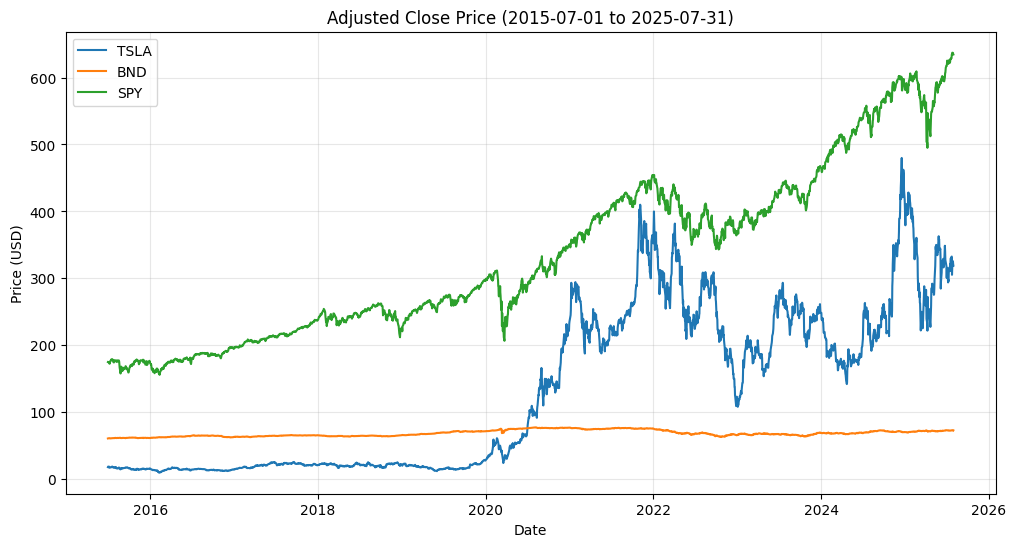

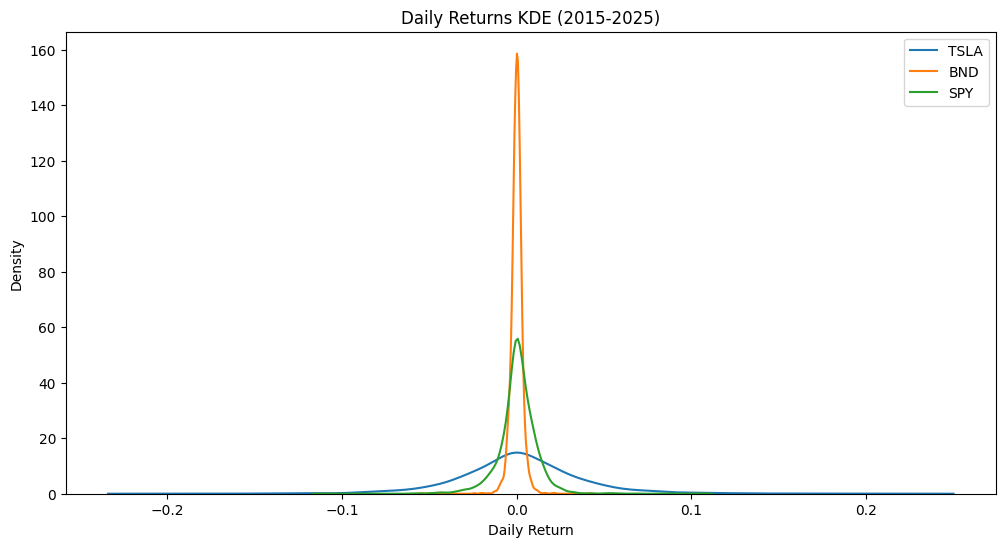

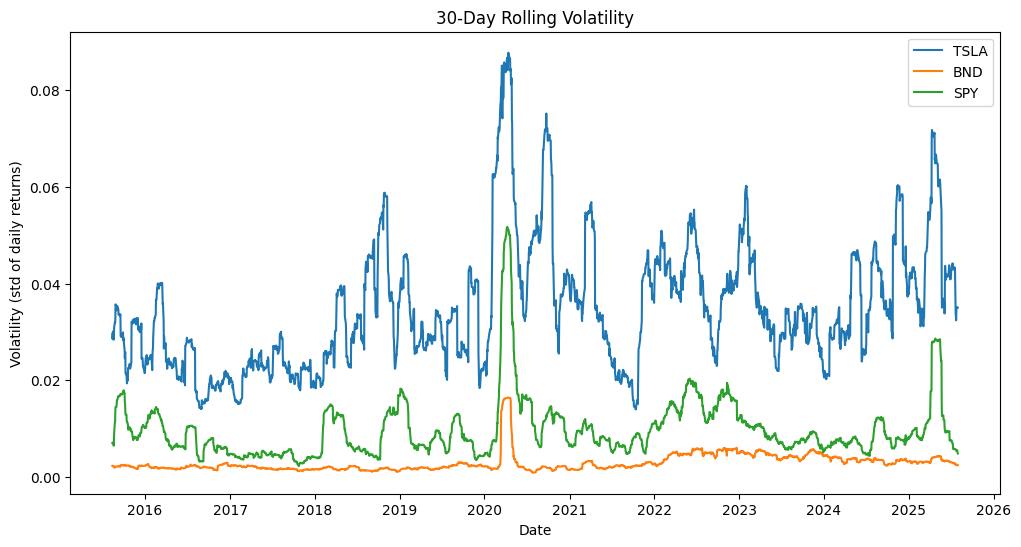

TSLA: Found 43 extreme return days (>|3 sigma|). Sample: 
Price       Adj Close Daily_Return
Ticker                            
Date                              
2018-08-02  23.302668     0.161880
2018-09-28  17.651333    -0.139015
2018-10-01  20.713333     0.173471
BND: Found 26 extreme return days (>|3 sigma|). Sample: 
Price       Adj Close Daily_Return
Ticker                            
Date                              
2020-03-10  74.094574    -0.013444
2020-03-11  72.691193    -0.018940
2020-03-12  68.737892    -0.054385
SPY: Found 33 extreme return days (>|3 sigma|). Sample: 
Price        Adj Close Daily_Return
Ticker                             
Date                               
2015-08-24  159.743546    -0.042107
2015-08-26  163.924744     0.038394
2016-06-24  175.040741    -0.035909

--- ADF Tests for TSLA ---
ADF test for TSLA Adj Close -> ADF=-1.4189, p=0.5732
   1% : -3.4330
   5% : -2.8627
   10% : -2.5674
   => Likely non-stationary (fail to reject H0)

ADF test for 

In [18]:
main()